# XPCS&XSVS Pipeline for Mulit-SAXS Runs
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [1]:
from chxanalys.chx_packages import *
from chxanalys.chx_xpcs_xsvs_jupyter import run_xpcs_xsvs_single
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
#%reset -f  #for clean up things in the memory

/opt/conda_envs/analysis/lib/python3.5/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "


## Control Multi-Runs Parameters

In [2]:
force_compress = False #True   #force to compress data 
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall = False   #run waterfall analysis
run_t_ROI_Inten =  False #True  #run  ROI intensity as a function of time
run_one_time = False   #run  one-time
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time = True#False #True #True #False    #run  two-time
run_four_time = True#False   #run  four-time
run_xsvs= False          #run visibility analysis
att_pdf_report = False    #attach the pdf report to CHX olog
qth_interest = 3      #the intested single qth             
use_sqnorm = False    #if True, use sq to normalize intensity
use_imgsum_norm=True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_1'     #for pdf report name

good_start = 5

taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None;  

In [3]:
force_compress = False #True   #force to compress data 
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall = True# #False   #run waterfall analysis
run_t_ROI_Inten = True# False #True  #run  ROI intensity as a function of time
run_one_time = True#False   #run  one-time
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time = True#False #True #True #False    #run  two-time
run_four_time = False #True#False   #run  four-time
run_xsvs=True           #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog


qth_interest = 3      #the intested single qth             
use_sqnorm = False    #if True, use sq to normalize intensity
use_imgsum_norm=True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_1'     #for pdf report name

good_start = 5


taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None;  

## Make a directory for saving results

In [4]:
CYCLE = '2016_3'
username = getpass.getuser()
#username = "colosqui"   #provide the username to force the results to save in that username folder
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/


In [5]:
#count : 1 ['6fdd55'] (scan num: 10457) (Measurement: sample X2 50nm Au in 2.5% PEG_slow_series_#0 )
uid_average=  'Au50_2p5PEGX2_vs_20us_120116' #give a meaningful folder name 

data_dir_average = os.path.join( data_dir, uid_average +'/')
os.makedirs(data_dir_average, exist_ok=True)
print ( data_dir_average)

/XF11ID/analysis/2016_3/yuzhang/Results/Au50_2p5PEGX2_vs_20us_120116/


## Load Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [6]:
mask_path = '/XF11ID/analysis/2016_3/masks/'
mask_name = 'Nov28_4M_SAXS_mask.npy' 
#mask_name = 'Dec3_4M_SAXS_mask.npy'

<IPython.core.display.Javascript object>


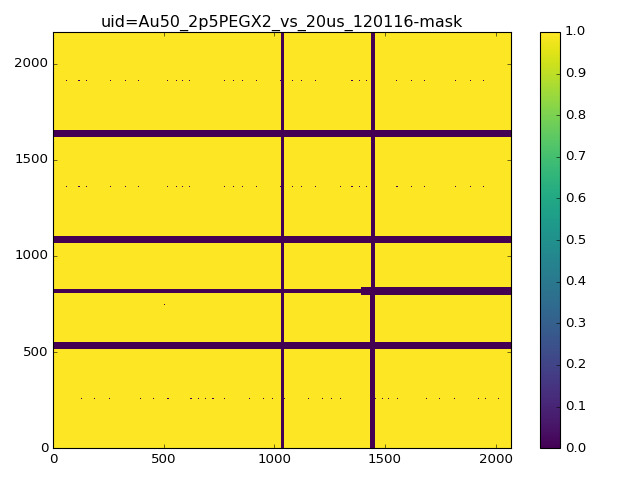

In [7]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = '%s-mask'%mask_name, reverse=True ) 
#mask *= pixel_mask
mask[:,2069] =0 # False  #Concluded from the previous results
#np.save(  data_dir + 'mask', mask)
show_img(mask,image_name = 'uid=%s-mask'%uid_average, save=True, path=data_dir_average)
mask_load=mask.copy()


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines to get data

In [111]:
start_time, stop_time = '2016-12-2  11:05', '2016-12-2  11:14:00' #for coralpor, 10,20,40,80,160,320,640   
sids, uids, fuids = find_uids(start_time, stop_time)
print( uids )
uid = uids[0]


Totally 7 uids are found.
['5e734cda' '0b3ea927' '10d1ebbf' 'af7e6c0e' '443c0f35' 'd851b99d'
 '43903256']


In [ ]:
guids, buids = check_bad_uids( uids, mask, img_choice_N = 3 )
print( 'The good uids are: %s.\nThe good uids length is %s.'%(guids, len(guids)) )

In [ ]:
gfuids = fuids[np.array( [ np.where( uids ==  s )[0][0] for s in guids  ] )]

# Don't Change these lines below here

In [ ]:
md = get_meta_data( uid )

In [ ]:
imgs = load_data( uid, md['detector'], reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )
imgsa = apply_mask( imgs, mask )

In [ ]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distanc', 'beam_center_x', 'beam_center_y', ] )

## Overwrite Some Metadata Due to Wrong Input

In [ ]:
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = md['detector_distance'] *1000     # detector to sample distance (mm)
try:
    exposuretime= md['cam_acquire_t']     #exposure time in sec
except:    
    exposuretime= md['count_time']     #exposure time in sec
acquisition_period = md['frame_time']   #acquisition time in sec
timeperframe = acquisition_period #for g2
center = [  int(md['beam_center_y']),int( md['beam_center_x'] ) ]  #beam center [y,x] for python image
#center = [ 2070-1381-0, 1475-4] 
setup_pargs=dict(uid=uid_average, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir_average)
print_dict( setup_pargs )

# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [ ]:
img_choice_N = 10
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgsa, img_samp_index, plot_ = False, uid =uid)
if avg_img.max() == 0:
    print('There are no photons recorded for this uid: %s'%uid)
    print('The data analysis should be terminated! Please try another uid.')

In [ ]:
show_saxs_qmap( avg_img, setup_pargs, width=600,vmin=.1, vmax=np.max(avg_img*.1), logs=True,
               image_name= 'uid=%s--img-avg-run1'%uid_average,  save=True) 

# Suppose we have all the parameters to define ROIs, if not use the "Single_Data" Pipeline

### Get circular average 
* Do plot and save q~iq


In [ ]:
hmask = create_hot_pixel_mask( avg_img, threshold = 100, center=center, center_radius= 400)
qp, iq, q = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs  )
plot_circular_average( qp, iq, q,  pargs=setup_pargs, 
                      xlim=[q.min(), q.max()], ylim = [iq.min(), iq.max()] )


### Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [ ]:
uniformq = True #False

### Define a non-uniform distributed rings by giving edges

In [ ]:
if not uniformq:    
    width = 0.0002    
    number_rings= 1    
    qcenters = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
    edges = get_non_uniform_edges(  qcenters, width, number_rings )    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [ ]:
if uniformq:    
    inner_radius= 0.005 #0.005 for 50 nm, 0.006, #for 10nm/coralpor
    outer_radius = 0.04 #0.04 for 50 nm, 0.05, #for 10nm/coralpor 
    num_rings = 12
    gap_ring_number = 6
    width =    ( outer_radius - inner_radius)/(num_rings + gap_ring_number)
    edges = None

In [ ]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                      unit='A',       pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 
q_ring_center = np.round( q_ring_center, 4)

In [ ]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth =700, alpha=.9,  
                 save=True, path=data_dir_average, uid=uid_average, vmin= np.min(avg_img), vmax= np.max(avg_img) ) 

In [ ]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid_average, xlim=[q.min(), q.max()],
                  ylim = [iq.min(), iq.max()],  save=True, path=data_dir_average)

# Configure Multi-Run

## Control Multi-Runs Parameters


In [ ]:

run_pargs=  dict(   
    force_compress =  force_compress,    #force to compress data 
    para_compress = para_compress,             #parallel compress
    run_fit_form = run_fit_form,             #run fit form factor  
    run_waterfall = run_waterfall,             #run waterfall analysis
    run_t_ROI_Inten = run_t_ROI_Inten,          #run  ROI intensity as a function of time
    run_one_time = run_one_time,      #run  one-time
    fit_g2_func = fit_g2_func,    
    run_two_time = run_two_time,    #run  two-time
    run_four_time = run_four_time,     #run  four-time
    run_xsvs=run_xsvs,            #run visibility analysis
    att_pdf_report = att_pdf_report,       #attach the pdf report to CHX olog
    show_plot = False,
                 
    CYCLE =  CYCLE, mask_path =  mask_path, mask_name =    mask_name, 
    good_start   =  good_start,
    uniformq = uniformq,    inner_radius= inner_radius, 
    outer_radius =   outer_radius,    num_rings =num_rings,   gap_ring_number = gap_ring_number, 
    #number_rings= number_rings,    
    qth_interest =  qth_interest, #the intested single qth,            
    use_sqnorm = use_sqnorm,  #if True, use sq to normalize intensity
    use_imgsum_norm=use_imgsum_norm,#if True use imgsum to normalize intensity for one-time calculatoin
    pdf_version = pdf_version #for pdf report name    
                )


# Do loop here

In [ ]:
do_loop = False
if do_loop:
    multi_res = {}
    t0 = time.time()
    for uid in guids:
        multi_res[uid] = run_xpcs_xsvs_single( uid, run_pargs= run_pargs, return_res= True )
    run_time(t0)    

### For Load results

In [ ]:
plt.close('all')

if not do_loop:
    multi_res = {}
    for uid, fuid in zip(guids,fuids):
        multi_res[uid] =  extract_xpcs_results_from_h5( filename = '%s_Res.h5'%fuid, import_dir = data_dir + uid +'/' )

In [ ]:
from chxanalys.chx_generic_functions import ( get_averaged_data_from_multi_res
                                            )

# Get and Plot Averaged Data

In [ ]:
mkeys = list(multi_res.keys())
print(mkeys)
print( multi_res[mkeys[0]].keys())

In [ ]:
avg_img = get_averaged_data_from_multi_res(  multi_res, keystr='avg_img' )
imgsum =  get_averaged_data_from_multi_res(  multi_res, keystr='imgsum' )
q_saxs = get_averaged_data_from_multi_res(  multi_res, keystr='q_saxs')
iq_saxs = get_averaged_data_from_multi_res(  multi_res, keystr='iq_saxs')
qt = get_averaged_data_from_multi_res(  multi_res, keystr='qt')
iqst = get_averaged_data_from_multi_res(  multi_res, keystr='iqst')
if run_waterfall: 
    wat = get_averaged_data_from_multi_res(  multi_res, keystr='wat')
if run_t_ROI_Inten:
    times_roi = get_averaged_data_from_multi_res(  multi_res, keystr='times_roi')
    mean_int_sets = get_averaged_data_from_multi_res(  multi_res, keystr='mean_int_sets')

if run_one_time:
    g2 = get_averaged_data_from_multi_res(  multi_res, keystr='g2' )
    taus = get_averaged_data_from_multi_res(  multi_res, keystr='taus' )
    
    data_dir_average    
    res_pargs = dict(taus=taus, q_ring_center=q_ring_center, path=data_dir_average, uid=uid_average ) 
    g2_pds = save_g2( g2, taus=taus, qr= q_ring_center, qz=None,
                     uid= uid_average +'--g2.csv', path= data_dir_average, return_res=True )
    
    g2_fit_result, taus_fit, g2_fit = get_g2_fit( g2,  res_pargs=res_pargs, 
                function = fit_g2_func,  vlim=[0.95, 1.05], fit_range= None,  
            fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
            guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,})  
    
    res_pargs_fit = dict(taus=taus_fit, q_ring_center= q_ring_center, path=data_dir,uid=uid  +'_g2_fit'       )
    g2_fit_paras = save_g2_fit_para_tocsv(g2_fit_result,  
                        filename= 'uid=%s'%uid_average  +'_g2_fit_paras.csv', path=data_dir_average )
    
if run_two_time:
    g12b = get_averaged_data_from_multi_res(  multi_res, keystr='g12b',different_length= True )
    g2b = get_averaged_data_from_multi_res(  multi_res, keystr='g2b' )
    tausb = get_averaged_data_from_multi_res(  multi_res, keystr='tausb' )

    res_pargsb = dict(taus=tausb, q_ring_center=q_ring_center,  uid=uid_average  , path= data_dir_average     )
    g2b_pds = save_g2( g2b, taus=tausb, qr= q_ring_center, qz=None, 
                       uid=uid_average +'--g2b.csv'  , path= data_dir_average, return_res=True )
    
    g2_fit_resultb, taus_fitb, g2_fitb = get_g2_fit( g2b,  res_pargs=res_pargsb, 
                function = 'stretched',  vlim=[0.95, 1.05], fit_range= None,  
                fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
                guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,})  
    
    res_pargs_fitb = dict(taus=taus_fitb, q_ring_center= q_ring_center,  
                         path=data_dir_average , uid=uid_average  +'_g2b_fit'       )
    
    g2b_fit_paras = save_g2_fit_para_tocsv(g2_fit_resultb, 
                    filename= 'uid=%s'%uid_average  + '_g2b_fit_paras--g2.csv', path=data_dir_average )

if run_four_time:
    g4 = get_averaged_data_from_multi_res(  multi_res, keystr='g4' )
    taus4 = get_averaged_data_from_multi_res(  multi_res, keystr='taus4' )
    res_pargs4 = dict(taus=taus4, q_ring_center=q_ring_center, path=data_dir_average, uid=uid_average     )     
    g4_pds = save_g2( g4, taus=taus4, qr= q_ring_center, qz=None, 
                     uid=uid_average +'--g4.csv', path= data_dir_average, return_res=True )  
    
if run_xsvs:    
    contrast_factorL = get_averaged_data_from_multi_res(  multi_res, keystr='contrast_factorL',different_length=False )
    times_xsvs = get_averaged_data_from_multi_res(  multi_res, keystr='times_xsvs',different_length=False )
    cont_pds = save_arrays( contrast_factorL, label= times_xsvs, filename = 'uid=%s--contrast_factorL.csv'%uid_average,
            path=data_dir_average,return_res=True )
    if False:
        spec_kmean = get_averaged_data_from_multi_res(  multi_res, keystr='spec_kmean' )
        spec_pds = get_averaged_data_from_multi_res(  multi_res, keystr='spec_pds', different_length=False )
        times_xsvs = get_averaged_data_from_multi_res(  multi_res, keystr='times_xsvs',different_length=False )
        spec_his,   spec_std = get_his_std_from_pds( spec_pds, his_shapes=None)
        ML_val, KL_val,K_ = get_xsvs_fit(  spec_his, spec_kmean,  spec_std, max_bins=2,varyK= False, )
        contrast_factorL = get_contrast( ML_val)
        spec_km_pds = save_KM(  spec_kmean, KL_val, ML_val, qs=q_ring_center,level_time=times_xsvs, uid=uid_average , path = data_dir_average )
        plot_xsvs_fit(  spec_his, ML_val, KL_val, K_mean = spec_kmean, spec_std = spec_std,xlim = [0,15], vlim =[.9, 1.1],
                uid=uid_average, qth= None, logy= True, times= times_xsvs, q_ring_center=q_ring_center, path=data_dir )



In [ ]:
show_saxs_qmap( avg_img, setup_pargs, width=600,vmin=.1, vmax=np.max(avg_img*.1), logs=True,
               image_name= 'uid=%s--img-avg'%uid_average,  save=True)
plot_circular_average( q_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, 
                      xlim=[q_saxs.min(), q_saxs.max()], ylim = [iq_saxs.min(), iq_saxs.max()] )
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth =700, alpha=.9,  
                 save=True, path=data_dir, uid=uid, vmin= np.min(avg_img), vmax= np.max(avg_img) )
plot_qIq_with_ROI( q_saxs, iq_saxs, q_ring_center, logs=True, uid=uid, xlim=[q_saxs.min(), q_saxs.max()],
                  ylim = [iq_saxs.min(), iq_saxs.max()],  save=True, path=data_dir)
plot1D( y = imgsum, title ='uid=%s--img-sum-t'%uid_average, xlabel='Frame', colors='b',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir_average)
plot_t_iqc( qt, iqst, frame_edge=None, pargs=setup_pargs, xlim=[qt.min(), qt.max()],
           ylim = [iqst.min(), iqst.max()], save=True )

In [ ]:
if run_waterfall: 
        plot_waterfallc( wat, qth_interest, aspect=None,vmax= np.max(wat), uid=uid_average, save =True, 
                        path=data_dir_average, beg= good_start)
if run_t_ROI_Inten:
    plot_each_ring_mean_intensityc( times_roi, mean_int_sets,  uid = uid_average, save=True, path=data_dir_average )        

In [ ]:
if run_one_time:
    plot_g2( g2, res_pargs= res_pargs, tau_2 = taus_fit, g2_2 = g2_fit,  
        fit_res= g2_fit_result, function = fit_g2_func, master_plot='qz',    
       vlim=[0.95, 1.05], geometry='saxs', append_name=  '-fit'  )    
    fit_q_rate(  q_ring_center[:],g2_fit_paras['relaxation_rate'], power_variable= False, 
           uid=uid_average  , path= data_dir_average)

In [ ]:
if run_two_time:
    show_C12(g12b, q_ind= qth_interest, N1= 0, N2=min( len(imgsa) ,1000), vmin=1.01, vmax=1.25,
             timeperframe=timeperframe,save=True,
             path= data_dir_average, uid = uid_average )
    plot_g2( g2b, res_pargs= res_pargsb, tau_2 = taus_fitb, g2_2 = g2_fitb,  
        fit_res= g2_fit_resultb, function = fit_g2_func, master_plot='qz',    
       vlim=[0.95, 1.05], geometry='saxs', append_name= '-b-fit'  )

In [ ]:
if run_two_time and run_one_time:
    #fit_q_rate(  q_ring_center[:],dfvb['relaxation_rate'], power_variable= False,  uid=uid +'-g2b' , path= data_dir )
    plot_saxs_two_g2( g2, taus, 
                 g2b, tausb, res_pargs=res_pargs, vlim=[.95, 1.05], uid= uid_average  )
if run_four_time:
    plot_saxs_g4( g4, taus4,  vlim=[0.95, 1.05], logx=True, res_pargs=res_pargs4) 

In [ ]:
if run_xsvs:
    plot_g2_contrast( contrast_factorL, g2, times_xsvs, taus, q_ring_center, 
                     vlim=[0.8,2.0], qth = qth_interest, uid=uid_average,path = data_dir_average, legend_size=14)
    plot_g2_contrast( contrast_factorL, g2, times_xsvs, taus, q_ring_center, 
                     vlim=[0.8,1.2], qth = None, uid=uid_average,path = data_dir_average, legend_size=4)

## Export Results to a h5 files

In [ ]:
md['mask_file']= mask_path + mask_name
md['mask'] = mask
md['NOTEBOOK_FULL_PATH'] = None
md['good_start'] = good_start
md['bad_frame_list'] = 'unknown' #bad_frame_list
md['avg_img'] = avg_img
md['ring_mask'] = ring_mask
md['q_ring_center']= q_ring_center
md['q_ring_val'] = q_ring_val
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]
md['beg'] = None
md['end'] = None
md['metadata_file'] = data_dir_average + 'md.csv-&-md.pkl'
psave_obj(  md, data_dir_average + 'uid=%s-md'%uid_average ) #save the setup parameters
save_dict_csv( md,  data_dir_average + 'uid=%s-md.csv'%uid_average, 'w')

Exdt = {} 
for k,v in zip( ['md', 'q_saxs', 'iq_saxs','iqst','qt','roi','avg_img','mask','pixel_mask', 'imgsum',], 
                [md, q_saxs, iq_saxs, iqst, qt,ring_mask,avg_img,mask,pixel_mask, imgsum, ] ):
    Exdt[ k ] = v
if run_waterfall:Exdt['wat'] =  wat
if run_t_ROI_Inten:Exdt['times_roi'] = times_roi;Exdt['mean_int_sets']=mean_int_sets
if run_one_time:
    for k,v in zip( ['taus','g2','g2_fit_paras'], [taus,g2,g2_fit_paras] ):Exdt[ k ] = v
if run_two_time:
    for k,v in zip( ['tausb','g2b','g2b_fit_paras', 'g12b'], [tausb,g2b,g2b_fit_paras,g12b] ):Exdt[ k ] = v
if run_four_time:
    for k,v in zip( ['taus4','g4'], [taus4,g4] ):Exdt[ k ] = v
if run_xsvs:
    for k,v in zip( ['times_xsvs','contrast_factorL'],[times_xsvs,contrast_factorL] ):
        Exdt[ k ] = v

In [ ]:
contr_pds = save_arrays( Exdt['contrast_factorL'], label= Exdt['times_xsvs'],
                       filename = 'uid=%s--contr.csv'%uid_average, path=data_dir,return_res=True )

In [ ]:
contr_pds

In [ ]:
export_xpcs_results_to_h5( uid_average + '_Res.h5', data_dir_average, export_dict = Exdt )
#extract_dict = extract_xpcs_results_from_h5( filename = uid_average + '_Res.h5', import_dir = data_dir_average )

## Create PDF report for each uid

In [ ]:
pdf_out_dir = data_dir
pdf_filename = "XPCS_Analysis_Report_for_uid=%s%s.pdf"%(uid_average,pdf_version)
if run_xsvs:
    pdf_filename = "XPCS_XSVS_Analysis_Report_for_uid=%s%s.pdf"%(uid_average,pdf_version)

In [ ]:
#pdf_filename = "XPCS_XSVS_Analysis_Report_for_uid=%s%s.pdf"%(uid_average,'_2')

In [ ]:
make_pdf_report( data_dir_average, uid_average, pdf_out_dir, pdf_filename, username, 
                    run_fit_form, run_one_time, run_two_time, run_four_time, run_xsvs
                   )

### Attach each g2 result to the corresponding olog entry

In [ ]:
if att_pdf_report:     
    os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
    os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'
    pname = pdf_out_dir + pdf_filename 
    atch=[  Attachment(open(pname, 'rb')) ] 
    try:
        update_olog_uid( uid= fuids[-1], text='Add XPCS Averaged Analysis PDF Report', attachments= atch )
    except:
        print("I can't attach this PDF: %s due to a duplicated filename. Please give a different PDF file."%pname)

In [ ]:
fuids[-1]

# The End!

In [ ]:
# For visibility multi-series each with multi-sub aveage

%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/Create_Report.py

sam='X1'
sp = 'Au10_7P5PEG' + sam 
uid_averages=  [ sp+'_vs_20us_120116', sp+'_vs_40us_120116', 
                sp+'_vs_80us_120116', sp+'_vs_160us_120116', sp+'_vs_320us_120116',sp+'_vs_640us_120116',]

uid_png = '6bde76'

times_xsvs, contrast_factorL = read_contrast_from_multi_h5( uids= uid_averages, path =data_dir0   )

res_640us=extract_xpcs_results_from_h5( filename= sp +'_vs_640us_120116_Res.h5', 
                                    import_dir = data_dir0 + sp+ '_vs_640us_120116/', onekey= None)
taus, g2 =res_640us['taus'],  res_640us['g2']

res_pargs = dict(taus= times_xsvs, q_ring_center=res_640us['md']['q_ring_center'],
                 path=data_dir0, uid= sam +'_vs_series'  ) 
   

In [ ]:
# For visibility multi series each with one file 

start_time, stop_time = '2016-12-2  11:05', '2016-12-2  11:14:00' #for coralpor, 10,20,40,80,160,320,640     
sids, uids, fuids = find_uids(start_time, stop_time)
uid_png = uids[-1]

times_xsvs, contrast_factorL = read_contrast_from_multi_h5( uids= uids, path =data_dir0   )

res_640us = extract_xpcs_results_from_h5( filename= uids[0] + '_Res.h5', 
                                    import_dir = data_dir0 + uids[0] + '/', onekey= None)
taus, g2 =res_640us['taus'],  res_640us['g2']

res_pargs = dict(taus= times_xsvs, q_ring_center=res_640us['md']['q_ring_center'],
                 path=data_dir0, uid= sam +'_vs_series'  ) 
   



plot_g2( contrast_factorL + 1, res_pargs= res_pargs,  tau_2= taus, g2_2 =g2,  master_plot='qz',    
       vlim=[0.95, 1.2], geometry='saxs', append_name=  '+xpcs'  )

## Export Results to a h5 files

png = 'uid='+sam+'_vs_series--g2-+xpcs.png'
atch=[  Attachment(open( data_dir0 + png, 'rb')) ]
#uid_png = 'dbf9a6'

update_olog_uid( uid= uid_png, text='Add XSVS-XPCS Analysis PNG file', attachments= atch )